<a href="https://colab.research.google.com/github/dasunpubudumal/deeplearning-repos/blob/main/Chapter_1_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Check internet access

In [ ]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

Set up the environment by installing requirements.

In [ ]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

## Download images of birds and forests

In [ ]:
from duckduckgo_search import DDGS
from fastcore.all import *

ddgs = DDGS()
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddgs.images(term, max_results=max_images)).itemgot('image')

Traverse through the `forest` and `bird` strings and download the images to respective directories.

In [ ]:
from fastdownload import download_url
from fastai.vision.all import *

searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


## Train the model

We need to prepare a training set and a validation set. Alongside, we need to set up a `DataLoaders` instance in `fast.ai`.

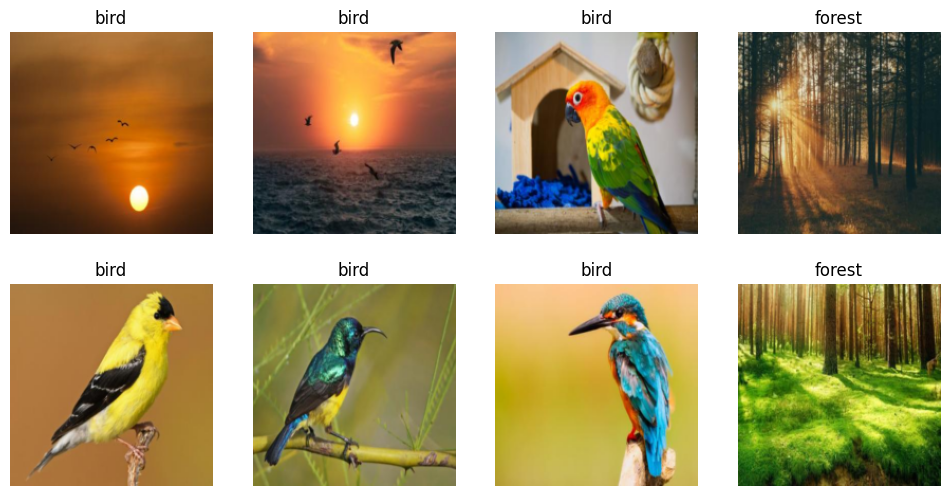

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=8)

* `blocks`: Specifies the input block and output block
* `get_items`: Specifies the function to receive inputs
* `splitter`: Specifies the splitter for train and validation data sets
* `get_y`: Specifies where to get the training labels (and validation labels)
* `item_tfms`: Item transformations (resize by squishing the image)

Train the model. We'll take the ResNet18 model trained with millions of data, and do some transfer learning. Transfer Learning makes a model tune its parameters so that it's easy to train with a small amount of data

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 3.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 41, in fetch
    data = next(self.dataset_iter)
  File "/opt/conda/lib/python3.10/site-packages/fastai/data/load.py", line 138, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/opt/conda/lib/python3.10/site-packages/fastcore/basics.py", line 230, in chunked
    res = list(itertools.islice(it, chunk_sz))
  File "/opt/conda/lib/python3.10/site-packages/fastai/data/load.py", line 168, in do_item
    try: return self.after_item(self.create_item(s))
  File "/opt/conda/lib/python3.10/site-packages/fastai/data/load.py", line 175, in create_item
    if self.indexed: return self.dataset[s or 0]
  File "/opt/conda/lib/python3.10/site-packages/fastai/data/core.py", line 447, in __getitem__
    res = tuple([tl[it] for tl in self.tls])
  File "/opt/conda/lib/python3.10/site-packages/fastai/data/core.py", line 447, in <listcomp>
    res = tuple([tl[it] for tl in self.tls])
  File "/opt/conda/lib/python3.10/site-packages/fastai/data/core.py", line 406, in __getitem__
    return self._after_item(res) if is_indexer(idx) else res.map(self._after_item)
  File "/opt/conda/lib/python3.10/site-packages/fastai/data/core.py", line 366, in _after_item
    def _after_item(self, o): return self.tfms(o)
  File "/opt/conda/lib/python3.10/site-packages/fastcore/transform.py", line 208, in __call__
    def __call__(self, o): return compose_tfms(o, tfms=self.fs, split_idx=self.split_idx)
  File "/opt/conda/lib/python3.10/site-packages/fastcore/transform.py", line 158, in compose_tfms
    x = f(x, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/fastcore/transform.py", line 81, in __call__
    def __call__(self, x, **kwargs): return self._call('encodes', x, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/fastcore/transform.py", line 91, in _call
    return self._do_call(getattr(self, fn), x, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/fastcore/transform.py", line 97, in _do_call
    return retain_type(f(x, **kwargs), x, ret)
  File "/opt/conda/lib/python3.10/site-packages/fastcore/dispatch.py", line 120, in __call__
    return f(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/fastai/vision/core.py", line 125, in create
    return cls(load_image(fn, **merge(cls._open_args, kwargs)))
  File "/opt/conda/lib/python3.10/site-packages/fastai/vision/core.py", line 98, in load_image
    im = Image.open(fn)
  File "/opt/conda/lib/python3.10/site-packages/PIL/Image.py", line 3236, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/bird_or_not/bird/8c1125b4-802c-4e43-9244-64b60fa9a6b6.jpg'
